In [3]:
import pandas as pd 
import numpy as np
import lightgbm as lgb # ML model
from sklearn.metrics import accuracy_score 
import zipfile as zp
zf = zp.ZipFile('new_raw.zip')
df = pd.read_csv(zf.open('new_raw.csv'))

/Users/brucez/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,18,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#drop useless features
drops = ['Unnamed: 0','Unnamed: 0.1','GEO.id','GEO.id2','GEO.display-label','NAICS.id','RCPSZFE.display-label','YEAR.id','city_x','state_x','GCT_STUB.target-geo-id','GCT_STUB.display-label_x','location','Area in square miles - Water area','Area in square miles - Total area','Density per square mile of land area - Population','Density per square mile of land area - Housing units','income_margin_error','state_y','city_y']
df = df.drop(drops,1)

In [3]:
#view the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4358918 entries, 0 to 4358917
Data columns (total 12 columns):
NAICS.display-label                 object
RCPSZFE.id                          int64
ESTAB                               int64
city-state                          object
Population                          object
Housing units                       object
Area in square miles - Land area    float64
income                              object
poverty_rate                        object
poverty_margin_error                object
Median_age                          object
age_margin_error                    object
dtypes: float64(1), int64(2), object(9)
memory usage: 399.1+ MB


In [4]:
# change to numerical type
df[['Population','Housing units','Area in square miles - Land area','poverty_rate','Median_age','income','poverty_margin_error','age_margin_error','age_margin_error']] = df[['Population','Housing units','Area in square miles - Land area','poverty_rate','Median_age','income','poverty_margin_error','age_margin_error','age_margin_error']].apply(pd.to_numeric,errors='coerce')


In [5]:
#drop NA values
df = df.dropna(axis = 0)

In [6]:
#complete dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3976037 entries, 0 to 4358917
Data columns (total 12 columns):
NAICS.display-label                 object
RCPSZFE.id                          int64
ESTAB                               int64
city-state                          object
Population                          float64
Housing units                       float64
Area in square miles - Land area    float64
income                              float64
poverty_rate                        float64
poverty_margin_error                float64
Median_age                          float64
age_margin_error                    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 394.4+ MB


In [7]:
#set model parameters
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':8,
    'metric': 'multi_logloss',
    'learning_rate': 0.002296,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

# define frequency encoding method give each object data a number as label
def fre_encode(object):
    i=0
    for item in df[object].unique():
        df[object].replace(item,i,inplace=True)
        i=i+1

In [8]:
# encoding features and results 
fre_encode('NAICS.display-label')
fre_encode('RCPSZFE.id')

In [9]:
# view result distribution
df['RCPSZFE.id'].value_counts()

0    1049991
1     990069
6     639273
5     360991
4     301009
7     278401
3     235558
2     120745
Name: RCPSZFE.id, dtype: int64

In [10]:
# random select to create an unbiased dataset
new_0 = df[df['RCPSZFE.id'] == 0].sample(120745)
new_1 = df[df['RCPSZFE.id'] == 1].sample(120745)
new_2 = df[df['RCPSZFE.id'] == 2].sample(120745)
new_3 = df[df['RCPSZFE.id'] == 3].sample(120745)
new_4 = df[df['RCPSZFE.id'] == 4].sample(120745)
new_5 = df[df['RCPSZFE.id'] == 5].sample(120745)
new_6 = df[df['RCPSZFE.id'] == 6].sample(120745)
new_7 = df[df['RCPSZFE.id'] == 7].sample(120745)
frames = [new_0,new_1,new_2,new_3,new_4,new_5,new_6,new_7]
test_df = pd.concat(frames)

In [14]:
# split dataset into training and predicting set 0.85 : 0.15
from sklearn.model_selection import train_test_split
predictors = ['ESTAB','Population','Housing units','Area in square miles - Land area','income','poverty_rate','Median_age','poverty_margin_error','age_margin_error']
X = test_df[predictors] 
y = test_df['RCPSZFE.id']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15, random_state=30)

In [18]:
lgtrain = lgb.Dataset(X_train,label=y_train) 
# cross validation
lgb_cv = lgb.cv(params, lgtrain, num_boost_round=200, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

# show multi-logloss every nround
print(nround)

# train the model
model = lgb.train(params, lgtrain, num_boost_round=nround)

# use the model for prediction
y_pred = model.predict(X_test)
mypredictions = []

# change the result into categories
for i in y_pred:
    mypredictions.append(np.argmax(i))

# show the accuracy
accuracy_score(y_test, mypredictions)

[20]	cv_agg's multi_logloss: 2.0781 + 4.21593e-06
[40]	cv_agg's multi_logloss: 2.07678 + 6.65762e-06
[60]	cv_agg's multi_logloss: 2.07554 + 1.0281e-05
[80]	cv_agg's multi_logloss: 2.07442 + 1.13762e-05
[100]	cv_agg's multi_logloss: 2.07326 + 1.42338e-05
[120]	cv_agg's multi_logloss: 2.07222 + 1.72888e-05
[140]	cv_agg's multi_logloss: 2.07106 + 2.08008e-05
[160]	cv_agg's multi_logloss: 2.06996 + 2.31979e-05
[180]	cv_agg's multi_logloss: 2.06902 + 2.38767e-05
[200]	cv_agg's multi_logloss: 2.06796 + 2.4631e-05
199


0.17746076442088698

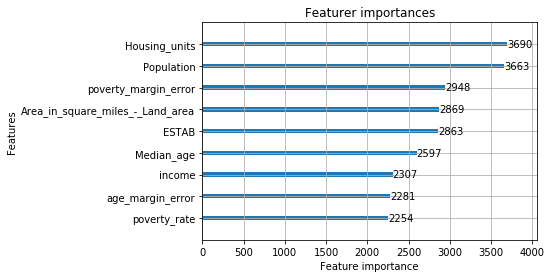

In [21]:
# visualize the importance of features
import matplotlib.pylab as plt
plt.figure(figsize=(80,20))
lgb.plot_importance(model, max_num_features=30)
plt.title("Featurer importances")
plt.show()